# Problem Statement
Given a set of items $I$, a set of votes $V$, a classification function $fn$, a classification threshold $th$ and a cost ratio for crowd to expert vote cost $cr$, for each item we want to find the minimum amount of votes needed to take the decision of continue collecting votes or swith to an expert vote. For this we describe a smart stopping algorithm. <br>
**We define a 3 methods structure**:
- the **classification fn** which returns the probability of an item being classified
- the **cost estimator** which returns the estimated cost for each item given the votes
- the **decision function** which returns a boolean decision for each item

In [1]:
#imports
import numpy as np

from tqdm import tqdm
import pandas as pd

#import cf's libs
from helpers.mv_single_binary import majority_voting
import helpers.algorithms_utils as alg_utils

rationale for the algorithm

In [2]:
# max 20 lines
'''
    Input:
        v - votes for item i
        ct - value between 0 and 1 for deciding if prob of data is enough or must continue
        cf - function to calculate how likely is to be classified
        cr - cost ratio between crowd to expert vote [0,1]
    Output:
        (cost_mean, cost_std)
'''
def cost_estimator(v, ct, cf, cr):
    actual_cost, expert_cost, must_continue = len(v) * cr, 1/cr, True
    simulated_costs = []
    for _ in range(drawing_simulations_amount):            
        while (must_continue == True):
            classification_prob = cf(alg_utils.input_adapter_single(v))
            if classification_prob > ct:
                must_continue = False            
                simulated_costs.append(actual_cost)
            else:
                vote = np.random.binomial(1, classification_prob)
                new_index = max(v.keys()) + 1
                v[new_index] = [vote]
                actual_cost += 1
                if(actual_cost >= (expert_cost * expert_cost_increment)):
                    must_continue = False
                    simulated_costs.append(actual_cost)

    return (np.mean(simulated_costs),np.std(simulated_costs))

In [3]:
# max 20 lines
'''
Function to answer: must continue collecting votes over each task?

Input:
items - set of items
votes - set of votes over each item
classification_threshold - value between 0 and 1 for deciding if prob of data is enough or must continue
cost_ratio - ratio of crowd to expert cost, [0,1]
classification_function - function to calculate how likely is to be classified

Output:
    Dictionary with the decision indexed by item_id
        {
            item_id: bool
            ...
            item_n: ...
        }
    Where False = Stop and True=Continue collecting votes
'''
def decision_function(items, votes, classification_threshold, cost_ratio, classification_function):      
    expert_cost = 1 / cost_ratio  
    results = dict.fromkeys(range(items), False)

    for item_id in range(items):            
        item_votes = votes[item_id].copy()
        actual_cost = len(item_votes) 
        classification_prob = classification_function(alg_utils.input_adapter_single(item_votes))
        if classification_prob <= classification_threshold:
            cost_mean, cost_std = cost_estimator(item_votes, classification_threshold, classification_function, cost_ratio)

            if(cost_mean <= expert_cost):
                results[item_id] = True

    return results

# Experiments

Here we discuss a few experiments, the objective is to compare the overall crowdsourcing cost and quality in the case where we have a smart stopping algorithm vs 
- the baseline approach where all items receive the same amount of votes
- an xx approach where you ask like 2 votes, if they disagree ask a third to break the tie

## 1) Basic settings: MV as classification function, Expected cost limited by expert cost

**Assumptions**:
- The items are evaluated over only 1 condition
- Difficulty of tasks are all equal
- There are no test questions
- The crowd workers accuracy is fixed

## 1.1) Logic

In [4]:
def generate_votes_1(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes, items_num)

            total_votes[i][worker_id] = [vote]

    #evaluate votes
    results = decision_function(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn'])
    #Check if must continue collecting votes
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    must_get_more_votes = len(items_predicted_classified) > 0

    while(must_get_more_votes):
        for i, v in items_predicted_classified.items():
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes, items_num)

            total_votes[i][worker_id] = [vote]             
        #end for
        results = decision_function(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn'])

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
    #end while        

    items_classification = alg_utils.classify_items(total_votes, gt, params['classification_fn'], ct)

    return [items_classification, total_votes]

In [5]:
def run_experiment_1():
    main_results = []

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
            
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

            ct_i_results = generate_votes_1(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[1]
            total_votes = ct_i_results[1]
            
            classified_amount, unclassified_amount, ct_i_crowd_cost, ct_i_total_cost = alg_utils.get_total_cost(total_votes, cr, cf, ct)
            
            ct_classified_amount.append(classified_amount)
            ct_unclassified_amount.append(unclassified_amount)
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
        #end for iterations

        main_results.append(
            [ct, 
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             #round(np.mean(crowd_cost) / items_num, 3), cost per item
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             np.mean(classified_amount),
             np.mean(unclassified_amount),
             np.mean(ct_loss),
             np.std(ct_loss),
             np.mean(ct_recall),
             np.std(ct_recall),
             np.mean(ct_precision),
             np.std(ct_precision)
            ])
    #end for thresholds

    return main_results

## 1.2) Hyperparameters

In [6]:
#main 
cf = majority_voting
cr = .01 #ratio 1:100
base_votes_per_item = 3

#cost estimator 
drawing_simulations_amount = 50
expert_cost_increment = 2

#crowd
workers_num = 1000
z = 0 #% cheaters
fixed_acc = True
workers_acc = .9

#ground truth 
items_num = 100
data_true_percentage = 1

#experiment 
cts = [.7, .75, .8, .85, .9, .95] #classification thresholds
iterations_per_ct = 50

## 1.3) Run experiment and see the results 

100%|██████████| 6/6 [14:31<00:00, 209.51s/it]


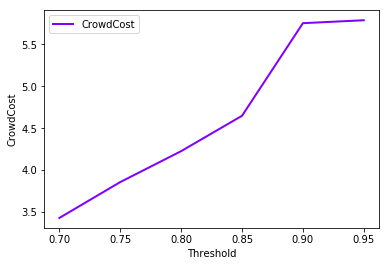

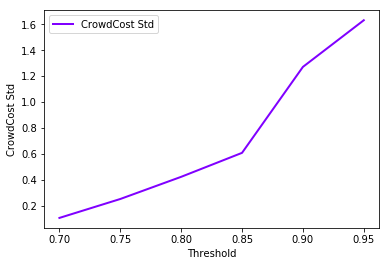

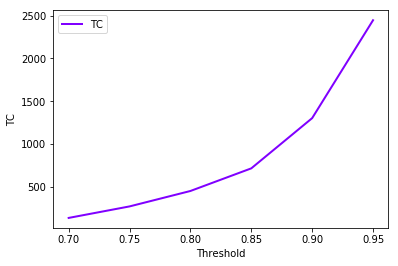

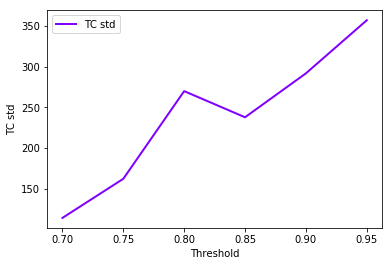

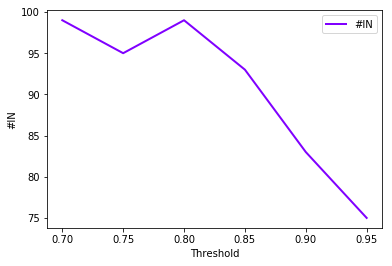

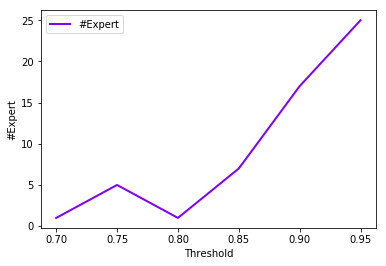

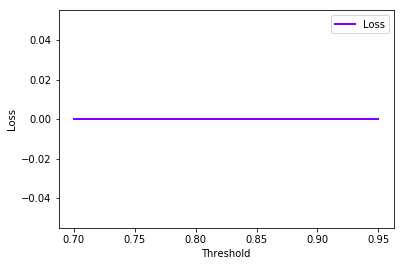

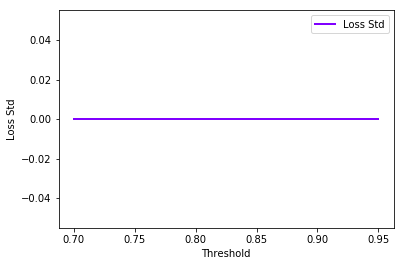

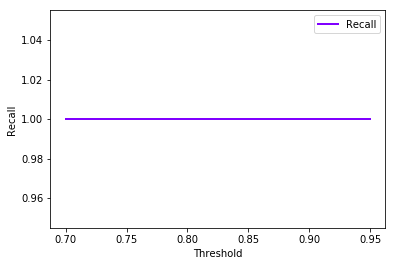

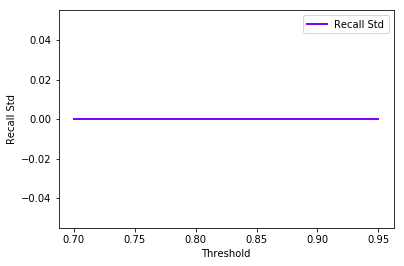

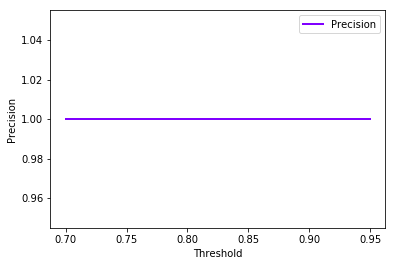

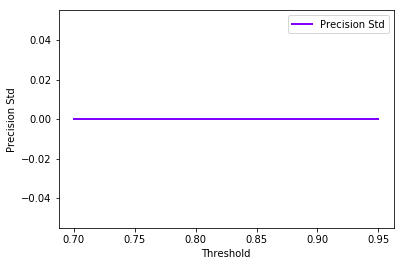

,Threshold,CrowdCost,CrowdCost Std,TC,TC std,#IN,#Expert,Loss,Loss Std,Recall,Recall Std,Precision,Precision Std
0,0.70,3.430,0.106,135.430,113.886,99.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.75,3.858,0.252,269.858,161.972,95.0,5.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.80,4.227,0.423,450.227,269.754,99.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.85,4.649,0.608,714.649,237.632,93.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.90,5.754,1.271,1301.754,291.620,83.0,17.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.95,5.789,1.631,2445.789,356.905,75.0,25.0,0.0,0.0,1.0,0.0,1.0,0.0


In [7]:
results_mv = run_experiment_1()
columns = ["CrowdCost","CrowdCost Std", "TC", "TC std","#IN","#Expert", "Loss", "Loss Std", "Recall", "Recall Std", "Precision", "Precision Std"]
pdColumns = ["Threshold"] + columns

#plots
i = 1
for column in columns:
    alg_utils.plot_results(cts, {column: [x[i] for x in results_mv]}, "Threshold", column)
    i += 1
#table    
pd.DataFrame(results_mv, columns=pdColumns)

## 2) MV with fixed number of votes per item

## 2.1) Logic

In [8]:
def generate_votes_2(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes, items_num)

            total_votes[i][worker_id] = [vote]

    #evaluate votes
    results = decision_function(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn'])

    items_classification = alg_utils.classify_items(total_votes, gt, params['classification_fn'], ct)

    return [items_classification, total_votes]

In [9]:
def run_experiment_2():
    main_results = []

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, workers_acc)
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
                
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

            ct_i_results = generate_votes_2(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[1]
            total_votes = ct_i_results[1]
            
            classified_amount, unclassified_amount, ct_i_crowd_cost, ct_i_total_cost = alg_utils.get_total_cost(total_votes, cr, cf, ct)
            
            ct_classified_amount.append(classified_amount)
            ct_unclassified_amount.append(unclassified_amount)
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
        #end for iterations

        main_results.append(
            [ct, 
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             #round(np.mean(crowd_cost) / items_num, 3), cost per item
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             np.mean(classified_amount),
             np.mean(unclassified_amount),
             np.mean(ct_loss),
             np.std(ct_loss),
             np.mean(ct_recall),
             np.std(ct_recall),
             np.mean(ct_precision),
             np.std(ct_precision)
            ])
    #end for thresholds

    return main_results

## 2.2) Hyperparameters

In [10]:
#main 
base_votes_per_item = 10

100%|██████████| 6/6 [01:01<00:00, 12.25s/it]


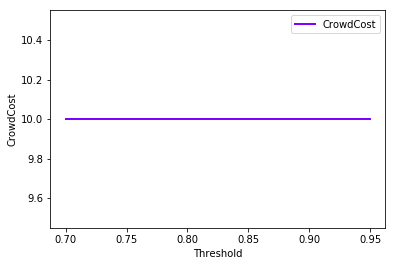

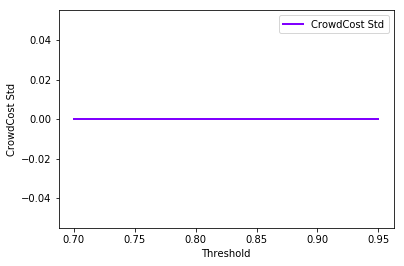

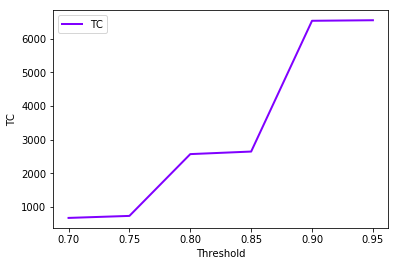

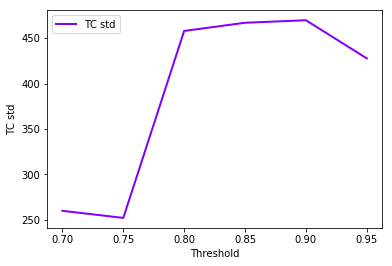

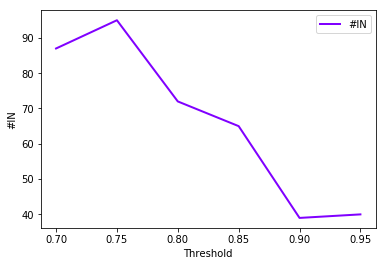

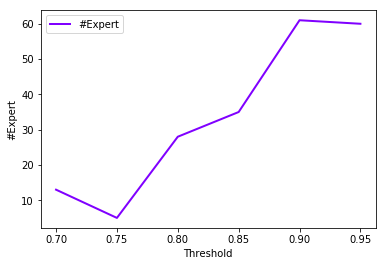

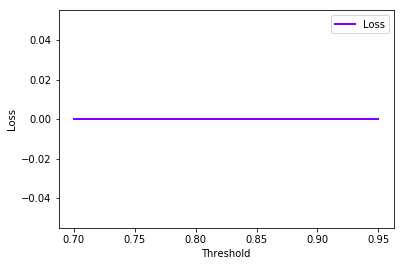

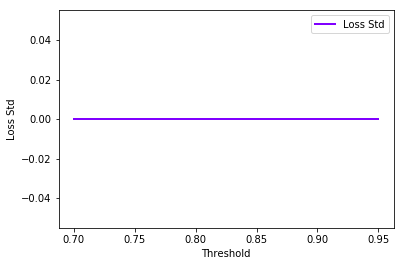

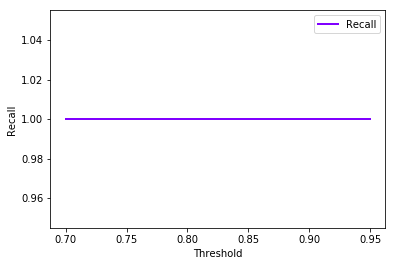

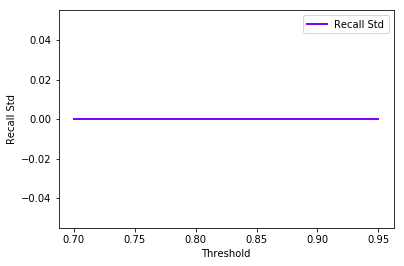

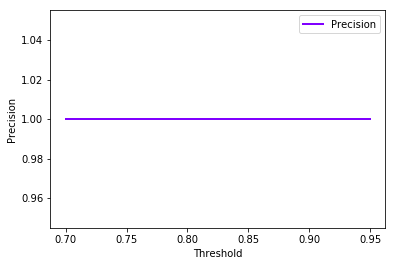

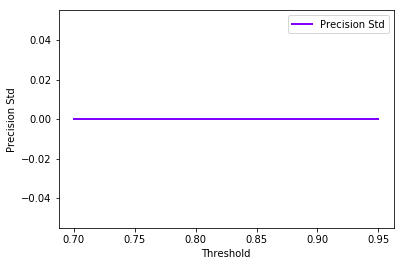

,Threshold,CrowdCost,CrowdCost Std,TC,TC std,#IN,#Expert,Loss,Loss Std,Recall,Recall Std,Precision,Precision Std
0,0.70,10.0,0.0,670.0,260.000,87.0,13.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.75,10.0,0.0,730.0,252.190,95.0,5.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.80,10.0,0.0,2570.0,457.821,72.0,28.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.85,10.0,0.0,2646.0,466.802,65.0,35.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.90,10.0,0.0,6540.0,469.574,39.0,61.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.95,10.0,0.0,6556.0,427.649,40.0,60.0,0.0,0.0,1.0,0.0,1.0,0.0


In [11]:
results_mv_baseline = run_experiment_2()
columns = ["CrowdCost","CrowdCost Std", "TC", "TC std","#IN","#Expert", "Loss", "Loss Std", "Recall", "Recall Std", "Precision", "Precision Std"]
pdColumns = ["Threshold"] + columns

#plots
i = 1
for column in columns:
    alg_utils.plot_results(cts, {column: [x[i] for x in results_mv_baseline]}, "Threshold", column)
    i += 1
#table    
pd.DataFrame(results_mv_baseline, columns=pdColumns)